# Imports / Setup

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from glob import glob

#U-Net
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.metrics import MeanIoU


#Self-written helper functions
from helpers.general_helpers import *

Segmentation Models: using `tf.keras` framework.


In [2]:
#For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

In [3]:
#For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

In [6]:
# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

#Location of test files
testimage_dir = './images/test/2023'
label_test = './labels/test'

# Get names of image and label files for test
testimage_files = sorted(glob(os.path.join(testimage_dir, '*.tif')))
testlabel_files = sorted(glob(os.path.join(label_test, '*.tif')))

# Reading data

## Data augmentation
Run only once (in total for all notebooks). Saves the data in training-ready format to cache/

In [4]:
#%run data_preprocessing.ipynb

## Training and Test Data
Our best results were received on all of the data in an unaugmented state

In [7]:
# ALL YEARS DATA
data = np.load("cache/unchanged_data_all_years.npz")
train_data_all_years = data['train_data']
train_labels_all_years = data['train_labels']
val_data_all_years = data['val_data']
val_labels_all_years = data['val_labels']

del data #For memory preservation

#TEST DATA
test_images = extract_channels(testimage_files)
test_labels = extract_labels(testlabel_files)

# Training

## Variables

In [14]:
#Variables
#Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
# For saving the best version of the model
checkpoint = ModelCheckpoint(
    filepath='iou_focused.keras', 
    monitor='val_loss',       
    save_best_only=True,     
    save_weights_only=False,  
    mode='auto',             
    verbose=1                 
)

## Setting up model

In [15]:
unet = Unet('resnet34', input_shape=(128, 128, 7), encoder_weights=None, classes = 7, activation = 'softmax')

In [16]:
#Code won't run without this
tf.compat.v1.reset_default_graph()

In [26]:
# Custom function for calculating iou to be 100% sure it is calculated correctly
# (unsure if tensorflow handles iou in one-hot data case)
# Takes the true values and predictions, cycles through all classes calcualting the iou for it, returns mean
def custom_iou(y_true, y_pred, num_classes = 7):
    #Undo one-hot encoding
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true_classes = tf.argmax(y_true, axis=-1)
    ious = []
    for i in range(num_classes):
        #Where both are this class
        intersection = tf.reduce_sum(tf.cast((y_pred_classes == i) & (y_true_classes == i), tf.float32))
        #Where at least one is this class
        union = tf.reduce_sum(tf.cast((y_pred_classes == i) | (y_true_classes == i), tf.float32))
        ious.append(intersection / (union + tf.keras.backend.epsilon()))
    return tf.reduce_mean(ious)

#Differentiable version of iou calculation. Essentially flattens the arrays so that each pixel has a single
#One-hot encoded field. Calculates union by multiplying (1 only where both 1) and union by adding and subtracting
#so that in case of union would not be 2
def iou_loss(y_true, y_pred):
    #Get the array of pixels one by one
    y_true = tf.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = tf.reshape(y_pred, [-1, y_pred.shape[-1]])

    intersection = tf.reduce_sum(y_true * y_pred, axis=0)  # Intersection per class
    union = tf.reduce_sum(y_true + y_pred, axis=0) - intersection  # Union per class

    iou_per_class = intersection / (union + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(iou_per_class)

callbacks = [early_stopping, checkpoint]

In [27]:
unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=iou_loss,
    metrics=['accuracy', custom_iou]
)

In [28]:
X_train = train_data_all_years
y_train = train_labels_all_years
X_val = val_data_all_years
y_val = val_labels_all_years

## Training Process

In [29]:
hist = unet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data=(X_val, y_val), callbacks = callbacks)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.4705 - custom_iou: 0.2561 - loss: 0.8327
Epoch 1: val_loss improved from inf to 0.66149, saving model to iou_focused.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 212s 792ms/step - accuracy: 0.4710 - custom_iou: 0.2565 - loss: 0.8323 - val_accuracy: 0.7327 - val_custom_iou: 0.4718 - val_loss: 0.6615
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7228 - custom_iou: 0.4715 - loss: 0.6147
Epoch 2: val_loss improved from 0.66149 to 0.52425, saving model to iou_focused.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 167s 741ms/step - accuracy: 0.7229 - custom_iou: 0.4716 - loss: 0.6146 - val_accuracy: 0.7739 - val_custom_iou: 0.5181 - val_loss: 0.5242
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.7609 - custom_iou: 0.5151 - loss: 0.5241
Epoch 3: val_loss improved from 0.52425 to 0.46496, saving model to iou_focused.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 168s 747ms/step - accuracy: 0.7609 - custom_iou: 0.5152 

## Evaluation

In [32]:
#Load best model
custom_objects = {'iou_loss': iou_loss, 'custom_iou': custom_iou}
best_model = load_model('iou_focused.keras',custom_objects = custom_objects )

#Predict and transform back to how the data originally was
predictions = best_model.predict(test_images)
prediction_values = array_to_int(predictions)

#Calculate accuracy
acc = np.sum(prediction_values == test_labels) / prediction_values.size
print(f"Accuracy of hypercolumns all data model: {acc}")

# Calculate IOU
iou_metric = tf.keras.metrics.MeanIoU(num_classes=7)
iou_metric.update_state(test_labels, prediction_values)
iou_values = iou_metric.result().numpy()
print(f"Intersection over union of hypercolumns all data model: {iou_values}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step
Accuracy of hypercolumns all data model: 0.7963695068359375
Intersection over union of hypercolumns all data model: 0.45505425333976746


## Plotting

In [38]:
#Read the training info from "training_logs/iou_focused.txt"
train_accuracies = []
train_ious = []
train_losses = []
val_accuracies = []
val_ious = []
val_losses = []
with open("training_logs/iou_focused.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()
    for i in range(3,len(lines),4):
        line = lines[i]
        if line[0] != "E": #Ignore epoch line
            lineparts = line.split("-")
            train_accuracies.append(float(lineparts[1].split()[1]))
            train_ious.append(float(lineparts[2].split()[1]))
            train_losses.append(float(lineparts[3].split()[1]))
            val_accuracies.append(float(lineparts[4].split()[1]))
            val_ious.append(float(lineparts[5].split()[1]))
            val_losses.append(float(lineparts[6].split()[1]))

[]

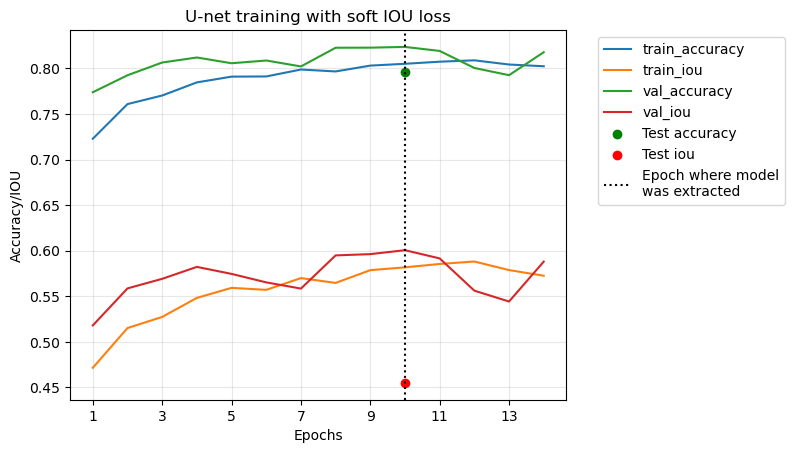

In [72]:
#Plot accuracies and ious
plottables = [train_accuracies, train_ious, val_accuracies, val_ious]
names = ["train_accuracy", "train_iou", "val_accuracy", "val_iou"]
from_epoch = 1
epoch_indices = range(len(plottables[0]))


#Plot all lines
for i in range(len(plottables)):
    plt.plot(epoch_indices[from_epoch:], plottables[i][from_epoch:], label=names[i])

#Plot test accuracy and iou
plt.scatter(len(epoch_indices)-5, 0.796, marker='o', color="green", label=f"Test accuracy")
plt.scatter(len(epoch_indices)-5, 0.455, marker='o', color="red", label=f"Test iou")

#Add a dotted line where the model was extracted
plt.axvline(x=len(epoch_indices)-5, color="black", linestyle="dotted", linewidth=1.5, label="Epoch where model\nwas extracted")

plt.xticks(range(from_epoch, len(plottables[0]), 2))
plt.grid(alpha=0.3)
    
#Lables
plt.title("U-net training with soft IOU loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/IOU")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.savefig("Unet_iouloss_training", bbox_inches='tight')
plt.plot()